# AI 221: Machine Exercise 6

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.neighbors import KernelDensity, LocalOutlierFactor
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.svm import OneClassSVM

### Trip Advisor Travel Reviews

The data set contains 980 unique users of Trip Advisor with 11 features each: Their average feedback 
scores on destinations in East Asia. These include art galleries, dance clubs, juice bars, restaurants, 
museums, resorts, parks, beaches, theaters, and religious institutions. The feedback score is a rating with 4-Excellent, 3-Very Good, 2-Average, 1-Poor, and 0-Terrible.

In [2]:
df_travel =  pd.read_csv("travel+reviews/tripadvisor_review.csv")
df_travel.head()

,User ID,Category 1,Category 2,Category 3,Category 4,Category 5,Category 6,Category 7,Category 8,Category 9,Category 10
0,User 1,0.93,1.8,2.29,0.62,0.80,2.42,3.19,2.79,1.82,2.42
1,User 2,1.02,2.2,2.66,0.64,1.42,3.18,3.21,2.63,1.86,2.32
2,User 3,1.22,0.8,0.54,0.53,0.24,1.54,3.18,2.80,1.31,2.50
3,User 4,0.45,1.8,0.29,0.57,0.46,1.52,3.18,2.96,1.57,2.86
4,User 5,0.51,1.2,1.18,0.57,1.54,2.02,3.18,2.78,1.18,2.54


In [3]:
df_travel.shape

(980, 11)

The goal of this problem is to find users with similar or dissimilar rating patterns

### a.

**Perform K-means clustering directly on the 11-feature data set. Based on the Silhouette 
Score, what is the best K?**

In [4]:
X = df_travel.iloc[:, 1:].to_numpy()
silhouette_avgs_a = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0).fit(X)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_avgs_a.append(silhouette_avg)
print(f"Max Silhouette Score: {max(silhouette_avgs_a)}")
print(f"k_value = {k_values[silhouette_avgs_a.index(max(silhouette_avgs_a))]}")

Max Silhouette Score: 0.300883545621953
k_value = 2


**Report the silhouette scores of each user as a bar plot.**

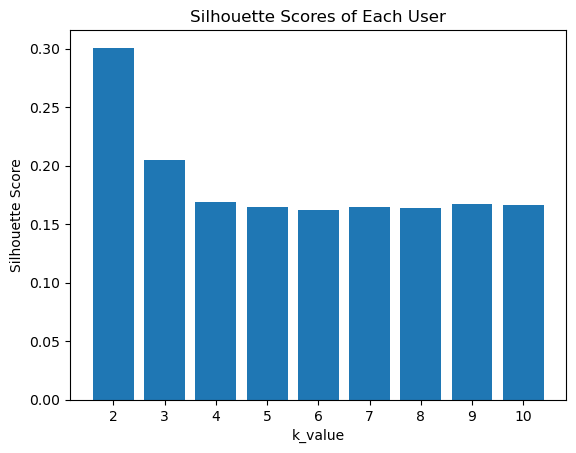

In [5]:
plt.bar(k_values, silhouette_avgs_a)
plt.xticks(k_values)
plt.title("Silhouette Scores of Each User")
plt.xlabel("k_value")
plt.ylabel("Silhouette Score")
plt.show()

### b.

**Redo item (a). Reduce the 11-feature data down to 2-features using PCA. Feed the 2-feature data into K-means clustering.**

In [6]:
pipeline_travel = make_pipeline(StandardScaler(), PCA(n_components=2))
X_pca = pipeline_travel.fit_transform(X)
silhouette_avgs_b = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0).fit(X_pca)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    silhouette_avgs_b.append(silhouette_avg)
max_silhouette = max(silhouette_avgs_b)
max_k_value = k_values[silhouette_avgs_b.index(max(silhouette_avgs_b))]
print(f"Max Silhouette Score: {max_silhouette}")
print(f"k_value = {max_k_value}")

Max Silhouette Score: 0.4333249083329544
k_value = 2


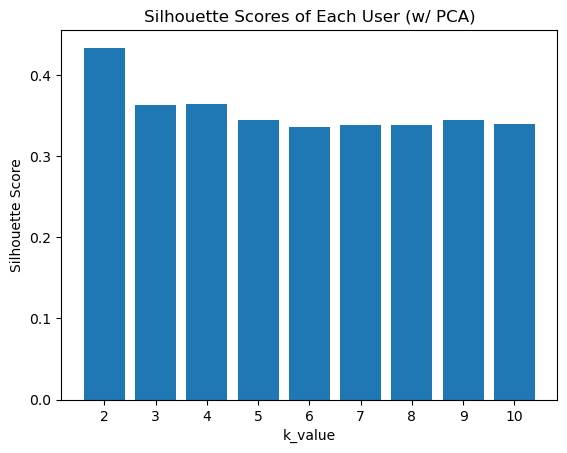

In [7]:
plt.bar(k_values, silhouette_avgs_b)
plt.xticks(k_values)
plt.title("Silhouette Scores of Each User (w/ PCA)")
plt.xlabel("k_value")
plt.ylabel("Silhouette Score")
plt.show()

**Display the 2-D data colored by cluster, for the best K.**

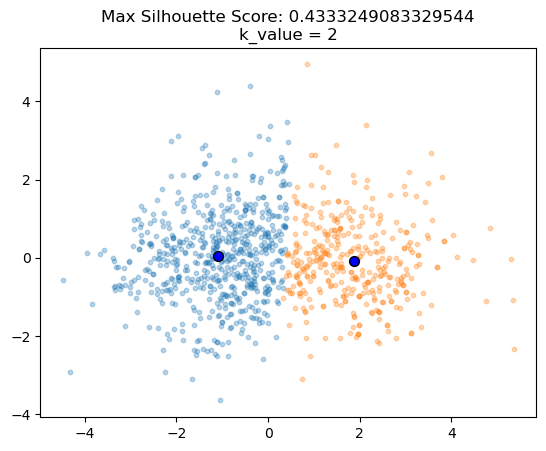

In [8]:
k = max_k_value
kmeans = KMeans(n_clusters=k, n_init=10, random_state=0).fit(X_pca)
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_
for j in range(k):
    plt.scatter(X_pca[cluster_labels == j, 0], X_pca[cluster_labels == j, 1], s=10, alpha=0.3)
plt.scatter(centroids[:, 0],centroids[:, 1], s=50, color="b", edgecolor="k")
plt.title(f"Max Silhouette Score: {silhouette_score(X_pca, cluster_labels)}\nk_value = {k}")
plt.show()

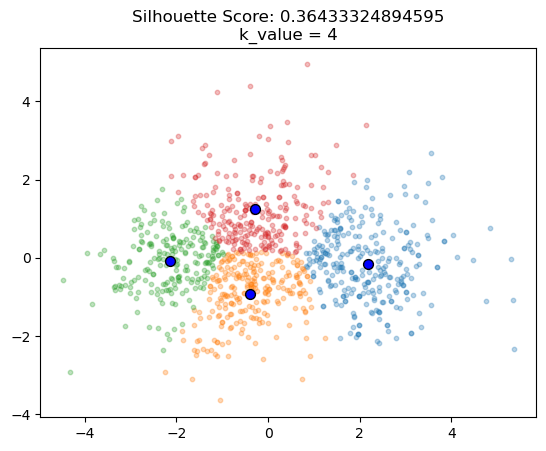

In [9]:
k = 4
kmeans = KMeans(n_clusters=k, n_init=10, random_state=0).fit(X_pca)
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_
for j in range(k):
    plt.scatter(X_pca[cluster_labels == j, 0], X_pca[cluster_labels == j, 1], s=10, alpha=0.3)
plt.scatter(centroids[:, 0],centroids[:, 1], s=50, color="b", edgecolor="k")
plt.title(f"Silhouette Score: {silhouette_score(X_pca, cluster_labels)}\nk_value = {k}")
plt.show()

Note: Although the highest silhoutte score is the one with 2 clusters, the second to the highest (4 clusters) can also be a reasonable choice given that the PCA graph provides a more interpretable visualization. Choosing the best k value can also depend on the specific purpose of the clustering, in this case are rating patters, which would probably desire more clusters. 

### c.

**Using Kernel Density Estimation, analyze the 2-D data set if there are users that can be 
considered outliers or unusual raters. Use a confidence level of 95%. Plot the KDE results in 2-D.**

Threshold (KDE) = 0.006580083253197451


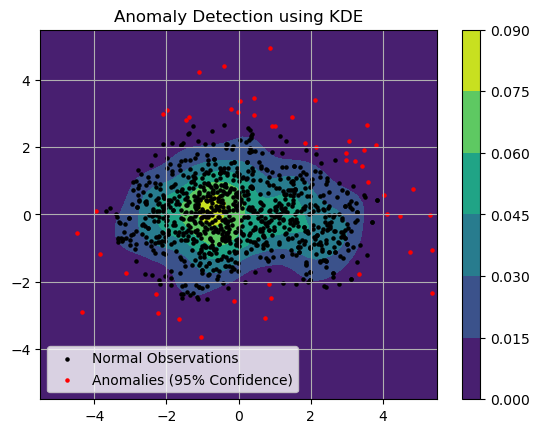

In [10]:
# Make a meshgrid for plotting surfaces
Xp, Yp = np.meshgrid(np.linspace(-5.5,5.5),np.linspace(-5.5,5.5))
XY = np.vstack([Xp.ravel(), Yp.ravel()]).T

# Generate the KDE surface as Z
kde = KernelDensity(kernel='gaussian',bandwidth=0.4).fit(X_pca)
Zp = np.exp(kde.score_samples(XY))
Zp = Zp.reshape(Xp.shape)

# Establish a confidence level of 95% (or 5% cutoff) 
# for the UCL using the quantile of kde_scores.
scores = kde.score_samples(X_pca)
threshold = np.quantile(scores,0.05)
print(f"Threshold (KDE) = {np.exp(threshold)}")

# Get the anomalous data points
normals = X_pca[scores > threshold,:]
anomals = X_pca[scores <= threshold,:]

cntr = plt.contourf(Xp, Yp, Zp, cmap='viridis')
plt.scatter(normals[:,0], normals[:,1], s=5, color='k', label='Normal Observations')
plt.scatter(anomals[:,0], anomals[:,1], s=5, color='r', label='Anomalies (95% Confidence)')
plt.title('Anomaly Detection using KDE')
plt.colorbar(cntr)
plt.legend()
plt.grid()
plt.show()

### Anomaly Detection in a Wastewater Treatment Plant

The data set contains 527 measurements of 38 process variables in a wastewater treatment plant in 
Spain: each row of values represent one day’s worth of measurements. These measurements are related 
to both the process equipment and the water quality, all of which are numeric and continuous.

In [11]:
df_water = pd.read_csv("water+treatment+plant/water-treatment.data", header=None)
df_water.head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,D-1/3/90,44101,1.50,7.8,?,407,166,66.3,4.5,2110,...,2000,?,58.8,95.5,?,70.0,?,79.4,87.3,99.6
1,D-2/3/90,39024,3.00,7.7,?,443,214,69.2,6.5,2660,...,2590,?,60.7,94.8,?,80.8,?,79.5,92.1,100
2,D-4/3/90,32229,5.00,7.6,?,528,186,69.9,3.4,1666,...,1888,?,58.2,95.6,?,52.9,?,75.8,88.7,98.5
3,D-5/3/90,35023,3.50,7.9,205,588,192,65.6,4.5,2430,...,1840,33.1,64.2,95.3,87.3,72.3,90.2,82.3,89.6,100
4,D-6/3/90,36924,1.50,8.0,242,496,176,64.8,4.0,2110,...,2120,?,62.7,95.6,?,71.0,92.1,78.2,87.5,99.5


In [12]:
df_water.shape

(527, 39)

The goal of this problem is to find days when we suspect anomalies in operation.

### a.

**Directly perform DBSCAN on the 38-feature data set. Decide on a suitable values of 
minPts and epsilon. List the outliers that you found.**

In [33]:
# Remove the day column and replace "?" with column mean
X_water_raw = df_water.iloc[:, 1:].replace("?", np.nan).to_numpy()
day = df_water.iloc[:, 0]
pipeline_water = make_pipeline(SimpleImputer(strategy="mean"),
                               StandardScaler())
X_water = pipeline_water.fit_transform(X_water_raw)
dbscan = DBSCAN(eps=10, min_samples=5)
labels = dbscan.fit_predict(X_water)
outliers = day[labels == -1]
print(outliers)

10     D-13/3/90
11     D-14/3/90
12     D-15/3/90
148    D-29/4/90
395    D-24/5/91
398    D-28/5/91
441    D-17/7/91
442    D-18/7/91
443    D-19/7/91
Name: 0, dtype: object


### b.

**Reduce the data set into 2 dimensions using a suitable dimensionality reduction method.**

In [34]:
kpca = KernelPCA(n_components=2, kernel="rbf", gamma=0.005)
X_water_kpca = kpca.fit_transform(X_water)

**In the 2-dimensional space, perform KDE, One-Class SVM, and Local Outlier Factor with a 
suitable set of hyper-parameters.**

Kernel Density Estimation

Threshold (KDE) = 0.4528258026129324


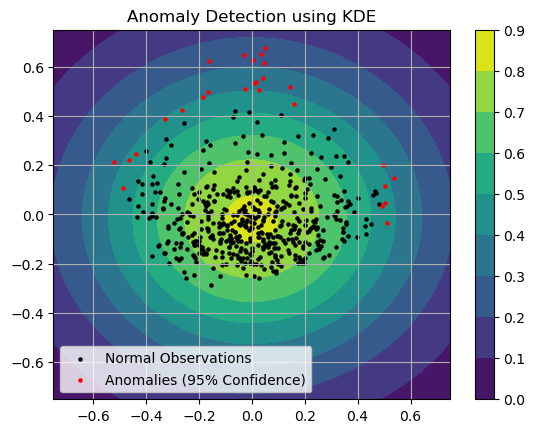

In [35]:
# Make a meshgrid for plotting surfaces
Xp, Yp = np.meshgrid(np.linspace(-0.75,0.75),np.linspace(-0.75,0.75))
XY = np.vstack([Xp.ravel(), Yp.ravel()]).T

# Generate the KDE surface as Z
kde = KernelDensity(kernel='gaussian',bandwidth=0.4).fit(X_water_kpca)
Zp = np.exp(kde.score_samples(XY))
Zp = Zp.reshape(Xp.shape)

# Establish a confidence level of 95% (or 5% cutoff) 
# for the UCL using the quantile of kde_scores.
kde_scores = kde.score_samples(X_water_kpca)
kde_threshold = np.quantile(kde_scores,0.05)
print(f"Threshold (KDE) = {np.exp(kde_threshold)}")

# Get the anomalous data points
normals = X_water_kpca[kde_scores > kde_threshold,:]
anomals = X_water_kpca[kde_scores <= kde_threshold,:]

cntr = plt.contourf(Xp, Yp, Zp, cmap='viridis')
plt.scatter(normals[:,0], normals[:,1], s=5, color='k', label='Normal Observations')
plt.scatter(anomals[:,0], anomals[:,1], s=5, color='r', label='Anomalies (95% Confidence)')
plt.title('Anomaly Detection using KDE')
plt.colorbar(cntr)
plt.legend()
plt.grid()
plt.show()

One-Class SVM

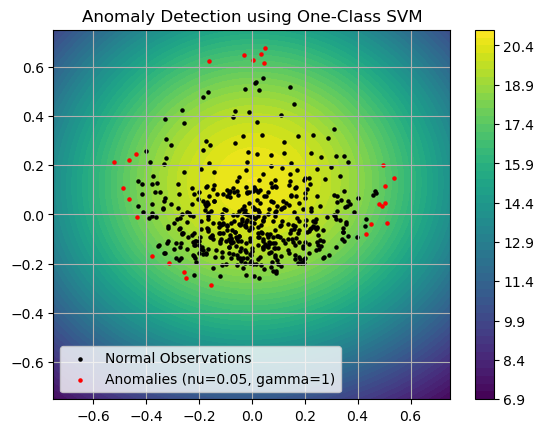

In [36]:
ocsvm = OneClassSVM(nu=0.05, gamma=1).fit(X_water_kpca)
Zp = ocsvm.score_samples(XY)
Zp = Zp.reshape(Xp.shape)

# Get the anomalous data points
ocsvm_y_pred = ocsvm.predict(X_water_kpca)
normals = X_water_kpca[ocsvm_y_pred == 1,:]
anomals = X_water_kpca[ocsvm_y_pred == -1,:]

cntr = plt.contourf(Xp, Yp, Zp, levels=50, cmap='viridis')
plt.scatter(normals[:,0], normals[:,1], s=5, color='k', label='Normal Observations')
plt.scatter(anomals[:,0], anomals[:,1], s=5, color='r', label='Anomalies (nu=0.05, gamma=1)')
plt.title('Anomaly Detection using One-Class SVM')
plt.colorbar(cntr)
plt.legend()
plt.grid()
plt.show()

Local Outlier Factor

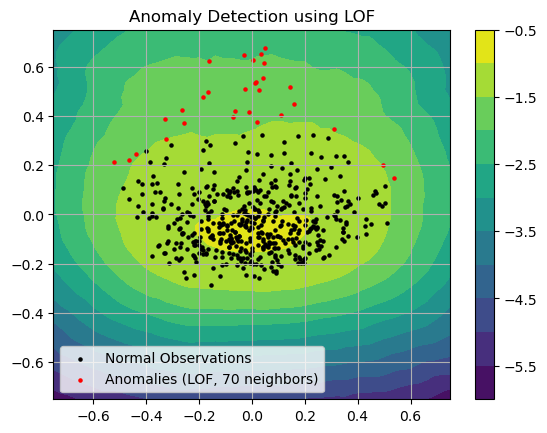

In [39]:
lof = LocalOutlierFactor(n_neighbors=70,novelty=True).fit(X_water_kpca)
Zp = lof.score_samples(XY)
Zp = Zp.reshape(Xp.shape)

# Get the anomalous data points
lof_y_pred = lof.predict(X_water_kpca)
normals = X_water_kpca[lof_y_pred == 1,:]
anomals = X_water_kpca[lof_y_pred == -1,:]

cntr = plt.contourf(Xp, Yp, Zp, levels=10, cmap='viridis')
plt.scatter(normals[:,0], normals[:,1], s=5, color='k', label='Normal Observations')
plt.scatter(anomals[:,0], anomals[:,1], s=5, color='r', label='Anomalies (LOF, 70 neighbors)')
plt.title('Anomaly Detection using LOF')
plt.colorbar(cntr)
plt.legend()
plt.grid()
plt.show()

**Compare the performance of the three methods.**

In [38]:
df_dbscan = outliers
df_kde = day[kde_scores <= kde_threshold]
df_ocsvm = day[ocsvm_y_pred == -1]
df_lof = day[lof_y_pred == -1]
merged_df = pd.DataFrame([df_dbscan, df_kde, df_ocsvm, df_lof]).T
merged_df.columns = ["DBSCAN", "KDE", "OCSVM", "LOF"]
merged_df_overlap = merged_df[merged_df.isna().sum(axis=1) < 3]
merged_df_overlap.iloc[merged_df_overlap.isna().sum(axis=1).argsort()]

,DBSCAN,KDE,OCSVM,LOF
395,D-24/5/91,D-24/5/91,D-24/5/91,D-24/5/91
398,D-28/5/91,D-28/5/91,D-28/5/91,D-28/5/91
10,D-13/3/90,D-13/3/90,NaN,D-13/3/90
401,NaN,D-31/5/91,D-31/5/91,D-31/5/91
170,NaN,D-25/7/90,D-25/7/90,D-25/7/90
274,NaN,D-30/11/90,D-30/11/90,D-30/11/90
292,NaN,D-22/10/90,D-22/10/90,D-22/10/90
210,NaN,D-13/8/90,D-13/8/90,D-13/8/90
78,NaN,D-5/6/90,D-5/6/90,D-5/6/90
441,D-17/7/91,D-17/7/91,NaN,D-17/7/91


The table above shows the outlier days with overlap to other methods. DBSCAN result was used as baseline because it utilized the untransformed data. LOF performs the best and it was able to identify the anomaly previously determined by DBSCAN that other methods coudln't. In the graph of LOF there's an emphasis on the most dense region and it seemed to identify outliers mostly in the upper portion where the data points are more distant. KDE have the most overlap with all the methods and it performed similarly to LOF. The graph of KDE also concentrates on the denser lower regions, identifying the outermost parts, particularly the upper portions and middle peripherals, as outliers. The OCSVM has lesser overlap and its graph covers the central part when looking at all the data. In turn, OCSVM identified outliers like in a circular pattern.